In [1]:
import os
import cv2
import torch
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Filtering Warinings
import warnings
warnings.filterwarnings("ignore")

In [4]:
sns.set(style='dark')

In [5]:
def plot(x, label):
  fig, axs = plt.subplots(8, 8, figsize=(10, 8))
  fig.suptitle(label)
  axs = axs.flatten()
  for img, ax in zip(x, axs):
    img = np.array(img.view(img_size,img_size,3))
    ax.axis('off')
    ax.imshow((img * 255).astype(np.uint8))
  plt.show()

# Dataset 

In [6]:
# Directories
training_dir = '/content/drive/MyDrive/cityscapes_data/train'
validation_dir = '/content/drive/MyDrive/cityscapes_data/val'

# Image sizes
img_size = 256

# Batch size
batch_size = 64

# Transforms on Dataset
transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize(img_size)])

In [7]:
class MyDataset(Dataset):
  def __init__(self, image_dir, image_size):
    self.image_dir = image_dir
    self.image_size = image_size
  
  def read_images(self):
    self.images = []
    self.masks = []

    for filename in os.listdir(self.image_dir):
      img_path = os.path.join(self.image_dir, filename)
      image = cv2.imread(img_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      if image is not None:
        mask = image[:, 256:, :]
        image = image[:, :256, :]

        self.images.append(image)
        self.masks.append(mask)

    self.masks = np.array(self.masks)/255
    np.save('masks.npy', self.masks, allow_pickle=True, fix_imports=True)
    del self.masks

    self.images = np.array(self.images)/255
    np.save('images.npy', self.images, allow_pickle=True, fix_imports=True)
    del self.images

In [8]:
# Training Dataset
dataset = MyDataset(training_dir, img_size)
dataset.read_images()

train_x = torch.FloatTensor(np.load('masks.npy'))
train_y = torch.FloatTensor(np.load('images.npy'))

train_x, train_y = train_x.view(len(train_x),3,img_size, img_size), train_y.view(len(train_y),3,img_size, img_size)

In [9]:
# Validation Dataset
dataset = MyDataset(validation_dir, img_size)
dataset.read_images()

val_x = torch.FloatTensor(np.load('masks.npy'))
val_y = torch.FloatTensor(np.load('images.npy'))

val_x, val_y = val_x.view(len(val_x),3,img_size, img_size), val_y.view(len(val_y),3,img_size, img_size)

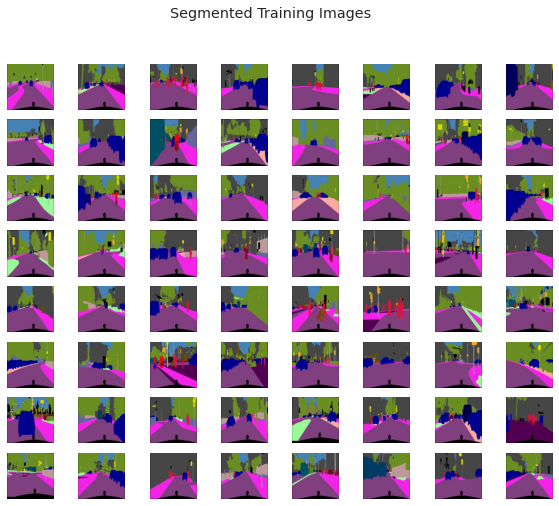

In [10]:
# Plotting Segmented Dataset (input)
plot(train_x[:64], 'Segmented Training Images')

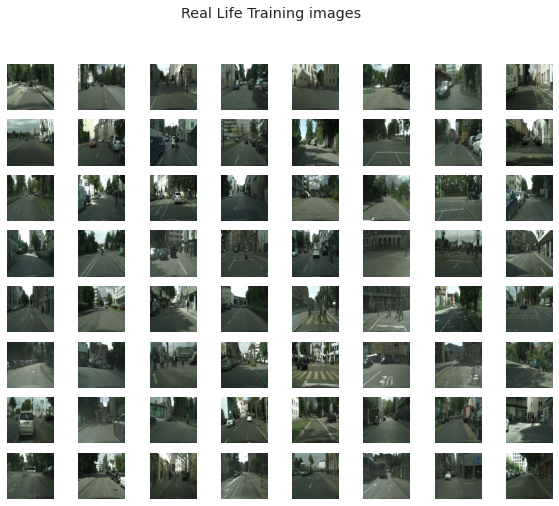

In [11]:
# Plotting Real Life Dataset (output)
plot(train_y[:64], 'Real Life Training images')

# pix2pix

Discriminator

In [12]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super(CNNBlock, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride, padding_mode = 'reflect', bias = False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )
  def forward(self, x):
    return self.main(x)

In [13]:
class Discriminator(nn.Module):
  def __init__(self, in_channels = 3, features = [64, 128, 256, 512]):
    super(Discriminator, self).__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels*2, features[0], 4, 2, 1, padding_mode = 'reflect'),
        nn.LeakyReLU(0.2)
    )
    
    layers = []
    in_channels = features[0]
    
    for feature in features[1:]:
      layers.append(CNNBlock(in_channels, feature, stride = 1 if feature == features[-1] else 2))
      in_channels = feature
    layers.append(nn.Conv2d(in_channels, 1, 4, 1, 1, padding_mode = 'reflect'))

    self.main = nn.Sequential(*layers)

  def forward(self, x, y):
    x = torch.cat([x, y], dim = 1)
    x = self.initial(x)
    return self.main(x)

In [14]:
def test():
  x = torch.randn(10, 3, 256, 256)
  y = torch.randn(10, 3, 256, 256)
  disc = Discriminator()
  output = disc(x, y)
  print(output.shape)
test()

torch.Size([10, 1, 26, 26])


Generator

In [15]:
class Block(nn.Module):
  def __init__(self, in_channels, out_channels, down = True, act = 'relu', use_dropout = False):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, 2, 1, padding_mode = 'reflect', bias = False)
        if down
        else
        nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU() if act == 'relu' else nn.LeakyReLU(0.2)
    )
    self.use_dropout = use_dropout
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv(x)
    return self.dropout(x) if self.use_dropout else x

In [16]:
class Generator(nn.Module):
  def __init__(self, in_channels = 3, features = 64):
    super().__init__()
    self.initial_down = nn.Sequential(
        nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode = 'reflect'),
        nn.LeakyReLU(0.2)
    )
    self.down1 = Block(features, features*2, down = True, act = 'Leaky', use_dropout = False)
    self.down2 = Block(features*2, features*4, down = True, act = 'Leaky', use_dropout = False)
    self.down3 = Block(features*4, features*8, down = True, act = 'Leaky', use_dropout = False)
    self.down4 = Block(features*8, features*8, down = True, act = 'Leaky', use_dropout = False)
    self.down5 = Block(features*8, features*8, down = True, act = 'Leaky', use_dropout = False)
    self.down6 = Block(features*8, features*8, down = True, act = 'Leaky', use_dropout = False)
    self.bottleneck = nn.Sequential(
        nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode = 'reflect'),
        nn.ReLU(True)
    )

    self.up1 = Block(features*8, features*8, down = False, act = 'relu', use_dropout = True)
    self.up2 = Block(features*8*2, features*8, down = False, act = 'relu', use_dropout = True)
    self.up3 = Block(features*8*2, features*8, down = False, act = 'relu', use_dropout = True)
    self.up4 = Block(features*8*2, features*8, down = False, act = 'relu', use_dropout = False)
    self.up5 = Block(features*8*2, features*4, down = False, act = 'relu', use_dropout = False)
    self.up6 = Block(features*4*2, features*2, down = False, act = 'relu', use_dropout = False)
    self.up7 = Block(features*2*2, features, down = False, act = 'relu', use_dropout = False)
    self.final_up = nn.Sequential(
        nn.ConvTranspose2d(features*2, in_channels, 4, 2, 1),
        nn.Tanh()
    )

  def forward(self, x):
    d1 = self.initial_down(x)
    d2 = self.down1(d1)
    d3 = self.down2(d2)
    d4 = self.down3(d3)
    d5 = self.down4(d4)
    d6 = self.down5(d5)
    d7 = self.down6(d6)

    bottleneck = self.bottleneck(d7)

    up1 = self.up1(bottleneck)
    up2 = self.up2(torch.cat([up1, d7], dim = 1))
    up3 = self.up3(torch.cat([up2, d6], dim = 1))
    up4 = self.up4(torch.cat([up3, d5], dim = 1))
    up5 = self.up5(torch.cat([up4, d4], dim = 1))
    up6 = self.up6(torch.cat([up5, d3], dim = 1))
    up7 = self.up7(torch.cat([up6, d2], dim = 1))
    return self.final_up(torch.cat([up7, d1], dim = 1))

In [17]:
def test():
  x = torch.randn(10, 3, 256, 256)
  gen = Generator()
  y = gen(x)
  print(y.shape)
test()

torch.Size([10, 3, 256, 256])


# Training

In [18]:
# GPU
if torch.cuda.device_count() != 0:
  device = 'cuda:0'

# Epochs
epochs = 150

# Lambdas
l1_lambda = 100
gp_lambda = 10

# Learning rate
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

In [19]:
def train(disc, gen, train_x, train_y, opt_disc, opt_gen, bce, l1_loss, g_scaler, d_scaler):
  batch_idx = 1
  for i in range(0, len(train_x), batch_size):
    x = train_x[i:i+batch_size].to(device)
    y = train_y[i:i+batch_size].to(device)

    # Training Discriminator
    with torch.cuda.amp.autocast():
      y_fake = gen(x)
      D_real = disc(x, y)
      D_fake = disc(x, y_fake.detach())
      D_real_loss = bce(D_real, torch.ones_like(D_real))
      D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
      D_loss = (D_real_loss + D_fake_loss)/2

    disc.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(opt_disc)
    d_scaler.update()

    # Training Generator
    with torch.cuda.amp.autocast():
      D_fake = disc(x, y_fake)
      G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
      l1 = l1_loss(y_fake, y)*l1_lambda
      G_loss = G_fake_loss + l1

    gen.zero_grad()
    g_scaler.scale(G_loss).backward()
    g_scaler.step(opt_gen)
    g_scaler.update()

    if batch_idx%10 == 0:
      print('[%d/40] Batch\tLoss_D: %.5f\tLoss_G: %.5f'
                    % (batch_idx,
                      D_loss.item(), G_loss.item()))
    batch_idx = batch_idx + 1

In [20]:
def main():
  disc = Discriminator().to(device)
  gen = Generator().to(device)

  opt_disc = optim.Adam(disc.parameters(), lr = lr, betas = (beta1, beta2))
  opt_gen = optim.Adam(gen.parameters(), lr = lr, betas = (beta1, beta2))

  bce = nn.BCEWithLogitsLoss()
  l1_loss = nn.L1Loss()

  g_scaler = torch.cuda.amp.GradScaler()
  d_scaler = torch.cuda.amp.GradScaler()

  for epoch in range(epochs):
    print(f'[{epoch+1}/{epochs}] Epochs')
    train(disc, gen, train_x, train_y, opt_disc, opt_gen, bce, l1_loss, g_scaler, d_scaler)
  
  return gen

gen = main()

[1/150] Epochs
[10/40] Batch	Loss_D: 0.55286	Loss_G: 36.92215
[20/40] Batch	Loss_D: 0.41823	Loss_G: 19.62787
[30/40] Batch	Loss_D: 0.19146	Loss_G: 17.16375
[40/40] Batch	Loss_D: 0.12045	Loss_G: 16.83140
[2/150] Epochs
[10/40] Batch	Loss_D: 0.05818	Loss_G: 15.69679
[20/40] Batch	Loss_D: 0.11766	Loss_G: 16.87444
[30/40] Batch	Loss_D: 0.08391	Loss_G: 16.41330
[40/40] Batch	Loss_D: 0.40040	Loss_G: 13.88456
[3/150] Epochs
[10/40] Batch	Loss_D: 0.65379	Loss_G: 12.46566
[20/40] Batch	Loss_D: 0.24862	Loss_G: 15.15567
[30/40] Batch	Loss_D: 0.16674	Loss_G: 16.17643
[40/40] Batch	Loss_D: 0.28627	Loss_G: 15.37518
[4/150] Epochs
[10/40] Batch	Loss_D: 0.36199	Loss_G: 13.16165
[20/40] Batch	Loss_D: 0.16405	Loss_G: 15.44985
[30/40] Batch	Loss_D: 0.15386	Loss_G: 15.37725
[40/40] Batch	Loss_D: 0.34194	Loss_G: 14.40983
[5/150] Epochs
[10/40] Batch	Loss_D: 0.11433	Loss_G: 12.48946
[20/40] Batch	Loss_D: 0.33489	Loss_G: 14.44948
[30/40] Batch	Loss_D: 0.18633	Loss_G: 14.01747
[40/40] Batch	Loss_D: 0.22944	Lo

In [21]:
# Saving The Model
torch.save(gen.state_dict(), 'pix2pix')

# Output

In [22]:
del train_x, train_y

In [27]:
# Generated Images
val_x = val_x.to(device)
y = gen(val_x[:64].view(-1,3,img_size,img_size))
y = y.cpu().detach()
y = torch.clip(y,0,1)

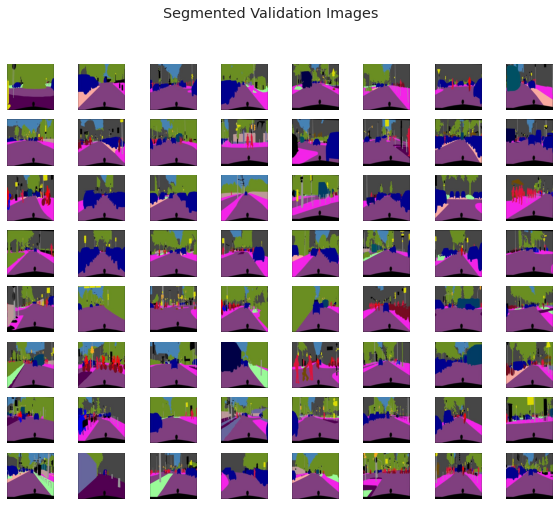

In [28]:
# Plotting Segmented Dataset (input)
plot(val_x[:64].cpu(), 'Segmented Validation Images')

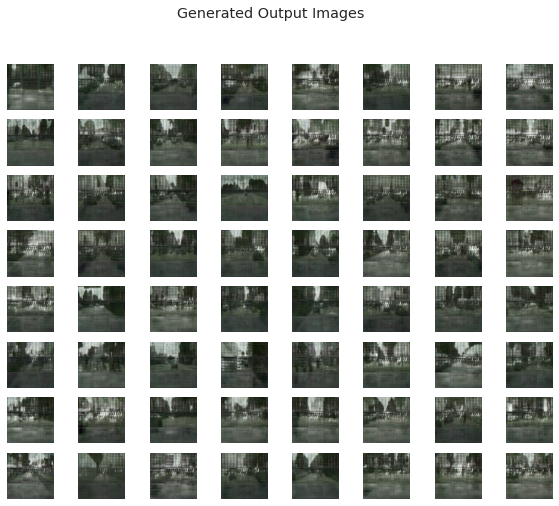

In [29]:
# Plotting Generated Images (output)
plot(y, 'Generated Output Images')

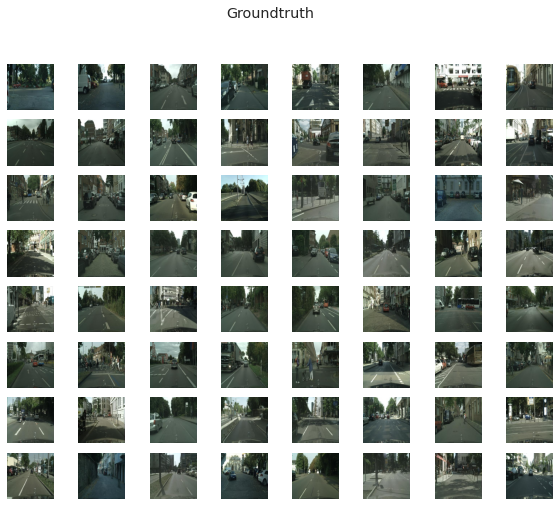

In [30]:
# Plotting GroundTruth (desired oput)
plot(val_y[:64], 'Groundtruth')